In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ara_proje_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/benign/aug_0_5669.png  
  inflating: train/benign/aug_0_6396.png  
  inflating: train/benign/aug_0_821.png  
  inflating: train/benign/aug_0_4940.png  
  inflating: train/benign/aug_0_10.png  
  inflating: train/benign/aug_0_9248.png  
  inflating: train/benign/aug_0_6968.png  
  inflating: train/benign/aug_0_6599.png  
  inflating: train/benign/aug_0_6012.png  
  inflating: train/benign/aug_0_2732.png  
  inflating: train/benign/aug_0_6190.png  
  inflating: train/benign/aug_0_824.png  
  inflating: train/benign/aug_0_9575.png  
  inflating: train/benign/aug_0_9135.png  
  inflating: train/benign/aug_0_7581.png  
  inflating: train/benign/aug_0_9464.png  
  inflating: train/benign/aug_0_3309.png  
  inflating: train/benign/aug_0_8782.png  
  inflating: train/benign/aug_0_6508.png  
  inflating: train/benign/aug_0_5852.png  
  inflating: train/benign/aug_0_783.png  
  inflating: train/benign/aug_0_3259.png  
  inflat

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50



# --- 1. YENİ PARAMETRELER ---
DATA_ROOT = "/content/" # Olası kök dizin
IMAGE_SIZE = (224, 224)
NEW_LEARNING_RATE = 0.001
MAX_EPOCHS = 50
PATIENCE = 15
BATCH_SIZE = 32

# --- 2. CALLBACK'LERİN TANIMLANMASI ---

# 5 epoch boyunca val_loss iyileşmezse eğitimi durdur ve en iyi ağırlıkları geri yükle
early_stopping = EarlyStopping(
monitor='val_loss',
patience=PATIENCE,# Sabır değeri
restore_best_weights=True,# En iyi ağırlıkları yükle
verbose=1
)

# Her epoch sonunda en iyi val_loss değerine sahip ağırlıkları kaydet
checkpoint_filepath = '/tmp/ResNet_best_weights_lr0001.weights.h5'
model_checkpoint = ModelCheckpoint(
filepath=checkpoint_filepath,
monitor='val_loss',
save_best_only=True,
verbose=1
)

# --- 3. VERİ YÜKLEYİCİLERİ (DOĞRU NORMALİZASYON) ---
datagen_rescale = ImageDataGenerator(rescale=1./255) # 0-1 Normalizasyonu

train_generator = datagen_rescale.flow_from_directory(
DATA_ROOT + 'train', target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
valid_generator = datagen_rescale.flow_from_directory(
DATA_ROOT + 'valid', target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- 4. MODEL TANIMI (Feature Extraction) ---


base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      pooling='avg',
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



base_model.trainable = False

x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. MODELİ DERLEME VE EĞİTİM ---
print(f"ResNet modeli LR={NEW_LEARNING_RATE} ile derleniyor...")

model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
loss='categorical_crossentropy',
metrics=['accuracy'])

print(f"\n--- ResNet Eğitimi Başlıyor (LR: {NEW_LEARNING_RATE}, Max Epoch: {MAX_EPOCHS}) ---\n")

history = model.fit(
train_generator,
epochs=MAX_EPOCHS,
validation_data=valid_generator,
callbacks=[early_stopping, model_checkpoint] # Callbacks eklendi
)

Found 7031 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
ResNet modeli LR=0.001 ile derleniyor...

--- ResNet Eğitimi Başlıyor (LR: 0.001, Max Epoch: 50) ---

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3487 - loss: 1.2231
Epoch 1: val_loss improved from inf to 1.10154, saving model to /tmp/ResNet_best_weights_lr0001.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.3488 - loss: 1.2228 - val_accuracy: 0.2917 - val_loss: 1.1015
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4106 - loss: 1.0793
Epoch 2: val_loss improved from 1.10154 to 0.95894, saving model to /tmp/ResNet_best_weights_lr0001.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.4106 - loss: 1.0792 - val_accuracy: 0.5833 - val_loss: 0.9589
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4396 - loss: 1.0612
Epoch 3: val_loss did not improve from 0.95894
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.4396 - loss: 1.0612 - val_accuracy: 0.6250 - val_loss: 0.9814
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4370 - loss: 1.0533
Epoch 4: val_loss did not improve from 0.95894
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.4371 - loss: 1.0533 - val_accuracy: 0.4500 - val_loss: 1.0643
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4775 - loss: 1.0348
Epoch 5: val_loss did not improve from 0.95894
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.4775 - loss: 1.0348 - val_accuracy: 0.4167 - val_loss: 1.0829
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4718 - loss: 1.0306
Epoch 6: val_loss did not improve f

220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.4977 - loss: 1.0147 - val_accuracy: 0.6167 - val_loss: 0.9398
Epoch 13/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4967 - loss: 1.0097
Epoch 13: val_loss did not improve from 0.93978
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.4966 - loss: 1.0097 - val_accuracy: 0.5250 - val_loss: 1.0007
Epoch 14/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5035 - loss: 1.0041
Epoch 14: val_loss did not improve from 0.93978
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.5035 - loss: 1.0041 - val_accuracy: 0.5500 - val_loss: 0.9643
Epoch 15/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4902 - loss: 1.0166
Epoch 15: val_loss improved from 0.93978 to 0.93959, saving model to /tmp/ResNet_best_weights_lr0001.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.4902 - loss: 1.0166 - val_accuracy: 0.6167 - val_loss: 0.9396
Epoch 16/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5160 - loss: 0.9979
Epoch 16: val_loss did not improve from 0.93959
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.5160 - loss: 0.9979 - val_accuracy: 0.4500 - val_loss: 1.0434
Epoch 17/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5068 - loss: 0.9965
Epoch 17: val_loss improved from 0.93959 to 0.92702, saving model to /tmp/ResNet_best_weights_lr0001.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.5068 - loss: 0.9965 - val_accuracy: 0.6417 - val_loss: 0.9270
Epoch 18/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5156 - loss: 0.9947
Epoch 18: val_loss did not improve from 0.92702
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.5156 - loss: 0.9948 - val_accuracy: 0.5750 - val_loss: 0.9765
Epoch 19/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5060 - loss: 0.9981
Epoch 19: val_loss did not improve from 0.92702
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.5060 - loss: 0.9980 - val_accuracy: 0.4417 - val_loss: 1.0796
Epoch 20/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5068 - loss: 1.0082
Epoch 20: val_loss did not improve from 0.92702
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.5068 - loss: 1.0082 - val_accuracy: 0.5917 - val_loss: 0.9792
Epoch 21/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5108 - loss: 0.9909
Epoch 21: val_loss did not i

220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.5168 - loss: 0.9971 - val_accuracy: 0.6333 - val_loss: 0.9192
Epoch 26/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5082 - loss: 0.9993
Epoch 26: val_loss did not improve from 0.91923
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.5082 - loss: 0.9993 - val_accuracy: 0.5417 - val_loss: 0.9831
Epoch 27/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5228 - loss: 0.9801
Epoch 27: val_loss did not improve from 0.91923
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.5227 - loss: 0.9801 - val_accuracy: 0.5417 - val_loss: 0.9900
Epoch 28/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5134 - loss: 0.9894
Epoch 28: val_loss did not improve from 0.91923
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.5134 - loss: 0.9894 - val_accuracy: 0.4250 - val_loss: 1.0810
Epoch 29/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5168 - loss: 0.9986
Epoch 29: val_loss did not i

In [ ]:
# Eğitimin temel metriklerini yazdıralım
print("\n--- EĞİTİM VE VALIDASYON ÖZETİ (HISTORY) ---")

# En iyi Validasyon Accuracy'i bulma
best_val_acc = max(history.history['val_accuracy'])
print(f"En Yüksek Validasyon Accuracy: {best_val_acc:.4f}")

# Sonuçları Training Seti üzerinde değerlendirelim
# Training Seti performansı (genellikle çok yüksektir)
train_results = model.evaluate(train_generator, verbose=0)
print(f"Training Seti Accuracy: {train_results[1]:.4f}")
print(f"Training Seti Loss: {train_results[0]:.4f}")


--- EĞİTİM VE VALIDASYON ÖZETİ (HISTORY) ---
En Yüksek Validasyon Accuracy: 0.6417
Training Seti Accuracy: 0.5173
Training Seti Loss: 0.9775


Found 115 images belonging to 3 classes.

--- NASNet (Makale Ayarları) TEST SETİ Metrikleri Hesaplanıyor ---

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Test Accuracy: 0.6870
Test Recall (Duyarlılık): 0.5525
Test Precision (Kesinlik): 0.7750
Test F1-Score: 0.5164


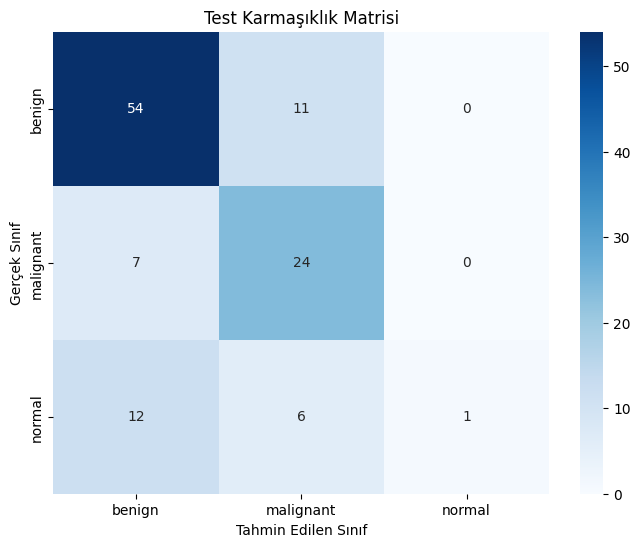


--- Tabloya Eklenecek Sonuçlar ---

ResNet-Large (Makale Ayarları) | Accuracy: 0.6870 | Recall: 0.5525 | Precision: 0.7750 | F1-Score: 0.5164

Karmaşıklık Matrisi (makale_confusion_matrix.png) oluşturuldu.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. TEST VERİ YÜKLEYİCİSİ (Normalizasyon: 0-1) ---
# Makale ayarlarına uygun olarak 0-1 normalizasyonunu kullanmalıyız.
datagen_test = ImageDataGenerator(rescale=1./255)

# Test generator'ı oluştur. Shuffle=False kritik!
test_generator = datagen_test.flow_from_directory(
    DATA_ROOT + 'test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Sınıfları doğru eşleştirmek için KARŞTIRMA KAPALI olmalı
)

# --- 2. TAHMİN VE METRİK HESAPLAMA ---

print("\n--- NASNet (Makale Ayarları) TEST SETİ Metrikleri Hesaplanıyor ---\n")

test_steps = int(np.ceil(test_generator.samples / BATCH_SIZE))
y_pred_proba_test = model.predict(test_generator, steps=test_steps)
y_pred_test = y_pred_proba_test.argmax(axis=1) # Olasılıklardan en yüksek olanın indeksini al
y_true_test = test_generator.classes # Gerçek etiketleri al

# Sınıf isimlerini al (Örn: benign, malignant, normal)
class_labels = list(test_generator.class_indices.keys())

# Metrikler
accuracy_test = accuracy_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test, average='macro', zero_division=0)
precision_test = precision_score(y_true_test, y_pred_test, average='macro', zero_division=0)
f1_test = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test Recall (Duyarlılık): {recall_test:.4f}")
print(f"Test Precision (Kesinlik): {precision_test:.4f}")
print(f"Test F1-Score: {f1_test:.4f}")

# --- 3. KARMAŞIKLIK MATRİSİ (CONFUSION MATRIX) OLUŞTURMA ---

cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=class_labels,
             yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Test Karmaşıklık Matrisi')
plt.savefig('Resnet_makale_confusion_matrix.png')
plt.show()

print("\n--- Tabloya Eklenecek Sonuçlar ---\n")
print(f"ResNet-Large (Makale Ayarları) | Accuracy: {accuracy_test:.4f} | Recall: {recall_test:.4f} | Precision: {precision_test:.4f} | F1-Score: {f1_test:.4f}")
print("\nKarmaşıklık Matrisi (makale_confusion_matrix.png) oluşturuldu.")

In [1]:
!unzip "/content/drive/MyDrive/Ara Proje/datalar/ara_proje_data.zip" -d "/content/datalar"

Archive:  /content/drive/MyDrive/Ara Proje/datalar/ara_proje_data.zip
   creating: /content/datalar/test/
   creating: /content/datalar/train/
   creating: /content/datalar/valid/
   creating: /content/datalar/train/benign/
   creating: /content/datalar/train/malignant/
   creating: /content/datalar/train/normal/
  inflating: /content/datalar/train/benign/benign (33).png  
  inflating: /content/datalar/train/benign/benign (2).png  
  inflating: /content/datalar/train/benign/benign (104).png  
  inflating: /content/datalar/train/benign/benign (111).png  
  inflating: /content/datalar/train/benign/benign (106).png  
  inflating: /content/datalar/train/benign/benign (120).png  
  inflating: /content/datalar/train/benign/benign (118).png  
  inflating: /content/datalar/train/benign/benign (115).png  
  inflating: /content/datalar/train/benign/benign (102).png  
  inflating: /content/datalar/train/benign/benign (11).png  
  inflating: /content/datalar/train/benign/benign (116).png  
  infla

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# --- 1. PARAMETRELER ---
DATA_ROOT = "/content/datalar/"
IMAGE_SIZE = (224, 224)
NEW_LEARNING_RATE = 0.0001 # Daha hassas öğrenme için düşürüldü
MAX_EPOCHS = 50
BATCH_SIZE = 32

# --- 2. VERİ YÜKLEYİCİLER (EN GÜVENLİ YÖNTEM) ---
datagen = ImageDataGenerator(rescale=1./255) # preprocess_input yerine standart rescale

train_generator = datagen.flow_from_directory(
    DATA_ROOT + 'train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_directory(
    DATA_ROOT + 'valid',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. MODEL TANIMI VE KATMANLARI AÇMA ---
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      pooling='avg',
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# TÜM MODELİ DONDURMAK YERİNE SON 30 KATMANI AÇIYORUZ
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = Dropout(0.5)(x) # Aşırı öğrenmeyi engellemek için doğrudan dropout
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. CALLBACK'LER ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint_filepath = '/tmp/ResNet_Fix_Best.weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- 5. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n🚀 ResNet50 KURTARMA OPERASYONU BAŞLIYOR...")
print("⚠️ Son 30 katman eğitilebilir durumda.")

history = model.fit(
    train_generator,
    epochs=MAX_EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# --- 6. MODELİ KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/"
os.makedirs(save_dir, exist_ok=True)
final_save_path = os.path.join(save_dir, "Resnet_model_with_BUSI.keras")

model.save(final_save_path)
print(f"\n✅ ResNet Temel Modeli Başarıyla Kaydedildi: {final_save_path}")

Found 7031 images belonging to 3 classes.
Found 120 images belonging to 3 classes.

🚀 ResNet50 KURTARMA OPERASYONU BAŞLIYOR...
⚠️ Son 30 katman eğitilebilir durumda.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5339 - loss: 0.9767
Epoch 1: val_loss improved from inf to 1.30985, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.5341 - loss: 0.9763 - val_accuracy: 0.5583 - val_loss: 1.3098
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6736 - loss: 0.7512
Epoch 2: val_loss did not improve from 1.30985
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.6736 - loss: 0.7512 - val_accuracy: 0.3750 - val_loss: 2.4060
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7137 - loss: 0.6745
Epoch 3: val_loss improved from 1.30985 to 1.15626, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.7137 - loss: 0.6746 - val_accuracy: 0.4250 - val_loss: 1.1563
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7298 - loss: 0.6369
Epoch 4: val_loss improved from 1.15626 to 0.80156, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.7298 - loss: 0.6369 - val_accuracy: 0.6750 - val_loss: 0.8016
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7471 - loss: 0.6137
Epoch 5: val_loss did not improve from 0.80156
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7470 - loss: 0.6137 - val_accuracy: 0.5417 - val_loss: 1.4642
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7624 - loss: 0.5690
Epoch 6: val_loss did not improve from 0.80156
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7624 - loss: 0.5690 - val_accuracy: 0.7083 - val_loss: 0.9502
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7590 - loss: 0.5775
Epoch 7: val_loss did not improve from 0.80156
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.7591 - loss: 0.5775 - val_accuracy: 0.2333 - val_loss: 5.1434
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7715 - loss: 0.5521
Epoch 8: val_loss improved from 0.8

220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.7715 - loss: 0.5521 - val_accuracy: 0.7000 - val_loss: 0.6967
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7962 - loss: 0.5104
Epoch 9: val_loss did not improve from 0.69669
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.7962 - loss: 0.5104 - val_accuracy: 0.7250 - val_loss: 0.8991
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8047 - loss: 0.4810
Epoch 10: val_loss did not improve from 0.69669
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8047 - loss: 0.4810 - val_accuracy: 0.2917 - val_loss: 9.5527
Epoch 11/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8177 - loss: 0.4557
Epoch 11: val_loss did not improve from 0.69669
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.8177 - loss: 0.4558 - val_accuracy: 0.5667 - val_loss: 2.2243
Epoch 12/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8135 - loss: 0.4524
Epoch 12: val_loss did not imp

Found 120 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 40 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



🔎 ResNet Test Tahminleri Yapılıyor...
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step

📊 RESNET50 BUSI TEMEL EĞİTİM TEST RAPORU
              precision    recall  f1-score   support

      benign       0.80      0.76      0.78        67
   malignant       0.61      0.53      0.57        32
      normal       0.57      0.76      0.65        21

    accuracy                           0.70       120
   macro avg       0.66      0.68      0.67       120
weighted avg       0.71      0.70      0.70       120



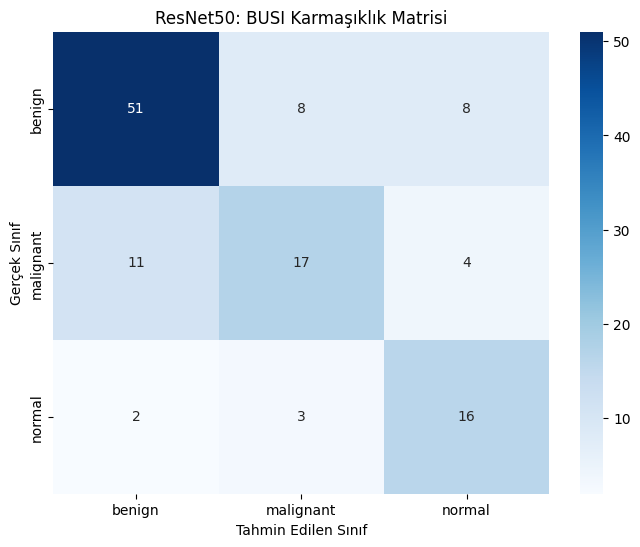

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. PARAMETRELER VE MODEL YÜKLEME
# Not: Eğer modelin ismi farklıysa burayı güncelle
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/Resnet_model_with_BUSI.keras"
model = load_model(model_path)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_ROOT = "/content/datalar/" # Test verilerinin olduğu ana dizin

# 2. TEST VERİ YÜKLEYİCİ (ResNet Standartlarında)
# Önemli: Daha önceki eğitimde rescale=1./255 kullandıysan burada da onu kullanmalısın
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    DATA_ROOT + 'valid', # Veya 'test' klasörün varsa orası
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. TAHMİNLERİ AL
print("\n🔎 ResNet Test Tahminleri Yapılıyor...")
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
target_names = list(test_generator.class_indices.keys())

# 4. RAPORLAMA
print("\n" + "="*50)
print("📊 RESNET50 BUSI TEMEL EĞİTİM TEST RAPORU")
print("="*50)
print(classification_report(y_true, y_pred, target_names=target_names))

# 5. KARMAŞIKLIK MATRİSİ GÖRSELLEŞTİRME
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('ResNet50: BUSI Karmaşıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Modeli ve Test Verisini Hazırla
# En son kaydettiğimiz kurtarma operasyonu modelini yüklüyoruz
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/Resnet_model_with_BUSI.keras"
best_model = load_model(model_path)

test_path = "/content/datalar/valid" # Veya 'test' klasörün
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 2. Tahminleri Al
print("\n🔎 ResNet Toplam Metrikleri Hesaplanıyor...")
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# 3. TOTAL (GENEL) METRİKLERİ HESAPLA
# 'weighted' ortalama, sınıflardaki örnek sayısına göre ağırlıklandırılmış gerçek başarıyı verir
total_accuracy = accuracy_score(y_true, y_pred)
total_precision = precision_score(y_true, y_pred, average='weighted')
total_recall = recall_score(y_true, y_pred, average='weighted')
total_f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*45)
print("📊 RESNET50 BUSI EĞİTİMİ: TOTAL METRİKLER")
print("="*45)
print(f"Toplam Doğruluk (Accuracy)  : {total_accuracy:.4f}")
print(f"Genel Kesinlik (Precision) : {total_precision:.4f}")
print(f"Genel Duyarlılık (Recall)  : {total_recall:.4f}")
print(f"Genel F1-Skoru (F1-Score)  : {total_f1:.4f}")
print("="*45)

Found 120 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 40 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



🔎 ResNet Toplam Metrikleri Hesaplanıyor...


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step

📊 RESNET50 BUSI EĞİTİMİ: TOTAL METRİKLER
Toplam Doğruluk (Accuracy)  : 0.7000
Genel Kesinlik (Precision) : 0.7068
Genel Duyarlılık (Recall)  : 0.7000
Genel F1-Skoru (F1-Score)  : 0.7001


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# --- 1. PARAMETRELER ---
DATA_ROOT = "/content/datalar/"
IMAGE_SIZE = (224, 224)
NEW_LEARNING_RATE = 0.00001 # Daha hassas öğrenme için düşürüldü
MAX_EPOCHS = 50
BATCH_SIZE = 32

# --- 2. VERİ YÜKLEYİCİLER (EN GÜVENLİ YÖNTEM) ---
datagen = ImageDataGenerator(rescale=1./255) # preprocess_input yerine standart rescale

train_generator = datagen.flow_from_directory(
    DATA_ROOT + 'train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_directory(
    DATA_ROOT + 'valid',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. MODEL TANIMI VE KATMANLARI AÇMA ---
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      pooling='avg',
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# TÜM MODELİ DONDURMAK YERİNE SON 30 KATMANI AÇIYORUZ
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = base_model.output
x = Dropout(0.5)(x) # Aşırı öğrenmeyi engellemek için doğrudan dropout
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. CALLBACK'LER ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint_filepath = '/tmp/ResNet_Fix_Best.weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- 5. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n🚀 ResNet50 KURTARMA OPERASYONU BAŞLIYOR...")
print("⚠️ Son 30 katman eğitilebilir durumda.")

history = model.fit(
    train_generator,
    epochs=MAX_EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# --- 6. MODELİ KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results2/"
os.makedirs(save_dir, exist_ok=True)
final_save_path = os.path.join(save_dir, "Resnet_model_with_BUSI(-5).keras")

model.save(final_save_path)
print(f"\n✅ ResNet Temel Modeli Başarıyla Kaydedildi: {final_save_path}")

Found 7031 images belonging to 3 classes.
Found 120 images belonging to 3 classes.

🚀 ResNet50 KURTARMA OPERASYONU BAŞLIYOR...
⚠️ Son 30 katman eğitilebilir durumda.
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5035 - loss: 1.0009
Epoch 1: val_loss improved from inf to 0.94138, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.5038 - loss: 1.0005 - val_accuracy: 0.6000 - val_loss: 0.9414
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6524 - loss: 0.7783
Epoch 2: val_loss did not improve from 0.94138
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.6525 - loss: 0.7782 - val_accuracy: 0.4667 - val_loss: 1.2986
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7220 - loss: 0.6512
Epoch 3: val_loss did not improve from 0.94138
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.7220 - loss: 0.6513 - val_accuracy: 0.6083 - val_loss: 1.0286
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7487 - loss: 0.6118
Epoch 4: val_loss did not improve from 0.94138
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.7487 - loss: 0.6119 - val_accuracy: 0.4583 - val_loss: 1.3045
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7731 - loss: 0.5496
Epoch 5: val_loss improved from 0.

220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.7731 - loss: 0.5496 - val_accuracy: 0.7583 - val_loss: 0.5326
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7930 - loss: 0.4949
Epoch 6: val_loss improved from 0.53260 to 0.51431, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.7930 - loss: 0.4950 - val_accuracy: 0.8000 - val_loss: 0.5143
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7970 - loss: 0.5018
Epoch 7: val_loss did not improve from 0.51431
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.7970 - loss: 0.5018 - val_accuracy: 0.6333 - val_loss: 1.0250
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8341 - loss: 0.4329
Epoch 8: val_loss did not improve from 0.51431
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.8340 - loss: 0.4330 - val_accuracy: 0.7333 - val_loss: 0.6494
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8372 - loss: 0.4192
Epoch 9: val_loss did not improve from 0.51431
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.8372 - loss: 0.4192 - val_accuracy: 0.7583 - val_loss: 0.6660
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8469 - loss: 0.3906
Epoch 10: val_loss did not improve

Found 120 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 64 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



🔎 ResNet50 (10^-5) Test Tahminleri Yapılıyor...
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

📊 RESNET50 (10^-5 + 50 KATMAN) TOTAL SONUÇLAR
Toplam Doğruluk (Accuracy)  : 0.8000
Genel Kesinlik (Precision) : 0.8072
Genel Duyarlılık (Recall)  : 0.8000
Genel F1-Skoru (F1-Score)  : 0.8016

📋 Detaylı Sınıf Raporu:
              precision    recall  f1-score   support

      benign       0.87      0.79      0.83        67
   malignant       0.74      0.81      0.78        32
      normal       0.71      0.81      0.76        21

    accuracy                           0.80       120
   macro avg       0.77      0.80      0.79       120
weighted avg       0.81      0.80      0.80       120



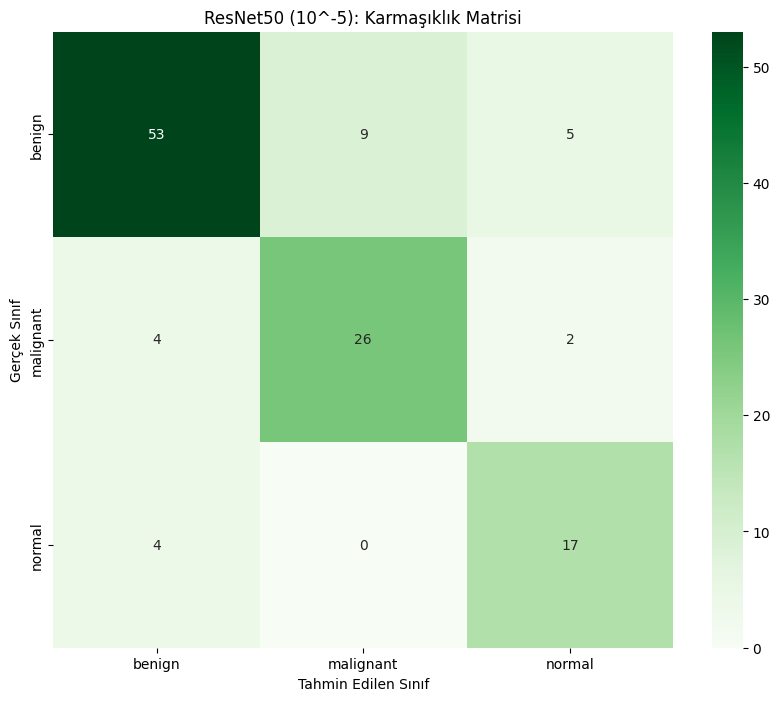

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. MODELİ VE TEST VERİSİNİ HAZIRLA
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results2/Resnet_model_with_BUSI(-5).keras"
best_model = load_model(model_path)

test_path = "/content/datalar/valid"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 2. TAHMİNLERİ AL
print("\n🔎 ResNet50 (10^-5) Test Tahminleri Yapılıyor...")
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())

# 3. TOTAL METRİKLERİ HESAPLA
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*45)
print("📊 RESNET50 (10^-5 + 50 KATMAN) TOTAL SONUÇLAR")
print("="*45)
print(f"Toplam Doğruluk (Accuracy)  : {accuracy:.4f}")
print(f"Genel Kesinlik (Precision) : {precision:.4f}")
print(f"Genel Duyarlılık (Recall)  : {recall:.4f}")
print(f"Genel F1-Skoru (F1-Score)  : {f1:.4f}")
print("="*45)

# 4. DETAYLI SINIF RAPORU
print("\n📋 Detaylı Sınıf Raporu:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. KARMAŞIKLIK MATRİSİ GÖRSELLEŞTİRME
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title('ResNet50 (10^-5): Karmaşıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# --- 1. PARAMETRELER ---
DATA_ROOT = "/content/datalar/"
IMAGE_SIZE = (224, 224)
NEW_LEARNING_RATE = 0.001 # Daha hassas öğrenme için düşürüldü
MAX_EPOCHS = 50
BATCH_SIZE = 32

# --- 2. VERİ YÜKLEYİCİLER (EN GÜVENLİ YÖNTEM) ---
datagen = ImageDataGenerator(rescale=1./255) # preprocess_input yerine standart rescale

train_generator = datagen.flow_from_directory(
    DATA_ROOT + 'train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_directory(
    DATA_ROOT + 'valid',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. MODEL TANIMI VE KATMANLARI AÇMA ---
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      pooling='avg',
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# TÜM MODELİ DONDURMAK YERİNE SON 30 KATMANI AÇIYORUZ
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = Dropout(0.5)(x) # Aşırı öğrenmeyi engellemek için doğrudan dropout
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. CALLBACK'LER ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint_filepath = '/tmp/ResNet_Fix_Best.weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- 5. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n🚀 ResNet50 KURTARMA OPERASYONU BAŞLIYOR...")
print("⚠️ Son 30 katman eğitilebilir durumda.")

history = model.fit(
    train_generator,
    epochs=MAX_EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# --- 6. MODELİ KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/"
os.makedirs(save_dir, exist_ok=True)
final_save_path = os.path.join(save_dir, "Resnet_model_with_BUSI(-3).keras")

model.save(final_save_path)
print(f"\n✅ ResNet Temel Modeli Başarıyla Kaydedildi: {final_save_path}")

Found 7031 images belonging to 3 classes.
Found 120 images belonging to 3 classes.

🚀 ResNet50 KURTARMA OPERASYONU BAŞLIYOR...
⚠️ Son 30 katman eğitilebilir durumda.
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4882 - loss: 1.0596
Epoch 1: val_loss improved from inf to 1.53707, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.4885 - loss: 1.0590 - val_accuracy: 0.3083 - val_loss: 1.5371
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6655 - loss: 0.7612
Epoch 2: val_loss did not improve from 1.53707
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.6656 - loss: 0.7611 - val_accuracy: 0.5583 - val_loss: 1.7255
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7141 - loss: 0.6767
Epoch 3: val_loss did not improve from 1.53707
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.7141 - loss: 0.6768 - val_accuracy: 0.2833 - val_loss: 3.5499
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7447 - loss: 0.6244
Epoch 4: val_loss improved from 1.53707 to 1.38547, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7447 - loss: 0.6244 - val_accuracy: 0.5250 - val_loss: 1.3855
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7556 - loss: 0.5953
Epoch 5: val_loss did not improve from 1.38547
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.7556 - loss: 0.5954 - val_accuracy: 0.4500 - val_loss: 2.0443
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7514 - loss: 0.5802
Epoch 6: val_loss did not improve from 1.38547
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7514 - loss: 0.5803 - val_accuracy: 0.2083 - val_loss: 8.0658
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7821 - loss: 0.5465
Epoch 7: val_loss improved from 1.38547 to 0.94925, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.7821 - loss: 0.5465 - val_accuracy: 0.6750 - val_loss: 0.9493
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7918 - loss: 0.5125
Epoch 8: val_loss improved from 0.94925 to 0.77998, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.7918 - loss: 0.5125 - val_accuracy: 0.7333 - val_loss: 0.7800
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8067 - loss: 0.4765
Epoch 9: val_loss did not improve from 0.77998
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8067 - loss: 0.4765 - val_accuracy: 0.2583 - val_loss: 4.9812
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8165 - loss: 0.4630
Epoch 10: val_loss did not improve from 0.77998
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.8165 - loss: 0.4630 - val_accuracy: 0.6833 - val_loss: 0.8005
Epoch 11/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8187 - loss: 0.4518
Epoch 11: val_loss did not improve from 0.77998
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.8187 - loss: 0.4518 - val_accuracy: 0.3500 - val_loss: 3.3548
Epoch 12/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8311 - loss: 0.4340
Epoch 12: val_loss did not imp

220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.8484 - loss: 0.4013 - val_accuracy: 0.7500 - val_loss: 0.7405
Epoch 15/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8605 - loss: 0.3617
Epoch 15: val_loss did not improve from 0.74050
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8604 - loss: 0.3618 - val_accuracy: 0.6667 - val_loss: 1.4174
Epoch 16/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8693 - loss: 0.3560
Epoch 16: val_loss did not improve from 0.74050
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.8693 - loss: 0.3561 - val_accuracy: 0.2750 - val_loss: 5.8168
Epoch 17/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8568 - loss: 0.3550
Epoch 17: val_loss did not improve from 0.74050
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.8568 - loss: 0.3550 - val_accuracy: 0.5833 - val_loss: 2.2181
Epoch 18/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8691 - loss: 0.3246
Epoch 18: val_loss did not i

In [8]:
!unzip "/content/drive/MyDrive/Ara Proje/datalar/ara_proje_data.zip" -d "/content/datalar"

Streaming output truncated to the last 5000 lines.
  inflating: /content/datalar/train/benign/aug_0_5669.png  
  inflating: /content/datalar/train/benign/aug_0_6396.png  
  inflating: /content/datalar/train/benign/aug_0_821.png  
  inflating: /content/datalar/train/benign/aug_0_4940.png  
  inflating: /content/datalar/train/benign/aug_0_10.png  
  inflating: /content/datalar/train/benign/aug_0_9248.png  
  inflating: /content/datalar/train/benign/aug_0_6968.png  
  inflating: /content/datalar/train/benign/aug_0_6599.png  
  inflating: /content/datalar/train/benign/aug_0_6012.png  
  inflating: /content/datalar/train/benign/aug_0_2732.png  
  inflating: /content/datalar/train/benign/aug_0_6190.png  
  inflating: /content/datalar/train/benign/aug_0_824.png  
  inflating: /content/datalar/train/benign/aug_0_9575.png  
  inflating: /content/datalar/train/benign/aug_0_9135.png  
  inflating: /content/datalar/train/benign/aug_0_7581.png  
  inflating: /content/datalar/train/benign/aug_0_9464

Found 115 images belonging to 3 classes.

🔍 Test verileri üzerinde tahminler yapılıyor...
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step

--- PERFORMANS RAPORU ---
              precision    recall  f1-score   support

      benign       0.77      0.89      0.83        65
   malignant       0.83      0.65      0.73        31
      normal       0.75      0.63      0.69        19

    accuracy                           0.78       115
   macro avg       0.79      0.72      0.75       115
weighted avg       0.79      0.78      0.78       115

Genel Test Doğruluğu (Accuracy): 0.7826


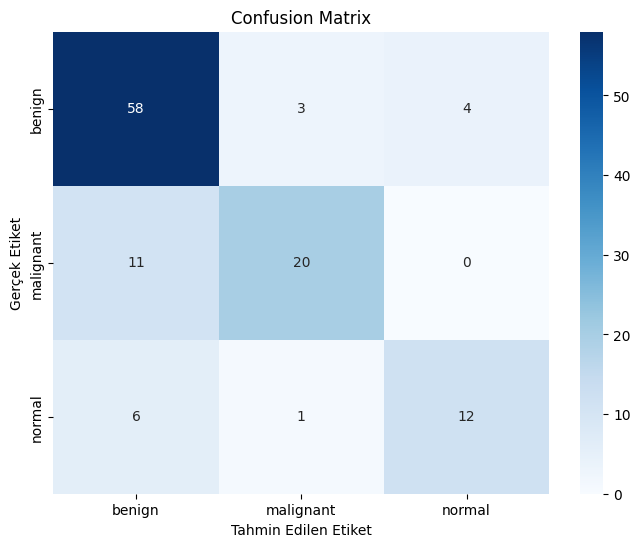

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. TEST VERİSİNİ YÜKLEME
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    DATA_ROOT + 'test', # Test klasörünüzün yolu
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Tahminlerin sırasının bozulmaması için False olmalı
)

# 2. TAHMİNLERİ ALMA
print("\n🔍 Test verileri üzerinde tahminler yapılıyor...")
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1) # En yüksek olasılıklı sınıfın indeksini al

# Gerçek etiketleri al
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 3. METRİKLERİ HESAPLAMA VE YAZDIRMA
print("\n--- PERFORMANS RAPORU ---")
print(classification_report(y_true, y_pred, target_names=class_labels))

acc = accuracy_score(y_true, y_pred)
print(f"Genel Test Doğruluğu (Accuracy): {acc:.4f}")

# 4. CONFUSION MATRIX (KARMAŞIKLIK MATRİSİ) ÇİZDİRME
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# --- 1. PARAMETRELER ---
DATA_ROOT = "/content/datalar/"
IMAGE_SIZE = (224, 224)
NEW_LEARNING_RATE = 0.0001 # Daha hassas öğrenme için düşürüldü
MAX_EPOCHS = 50
BATCH_SIZE = 32

# --- 2. VERİ YÜKLEYİCİLER (EN GÜVENLİ YÖNTEM) ---
datagen = ImageDataGenerator(rescale=1./255) # preprocess_input yerine standart rescale

train_generator = datagen.flow_from_directory(
    DATA_ROOT + 'train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_directory(
    DATA_ROOT + 'valid',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. MODEL TANIMI VE KATMANLARI AÇMA ---
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      pooling='avg',
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# TÜM MODELİ DONDURMAK YERİNE SON 30 KATMANI AÇIYORUZ
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = Dropout(0.5)(x) # Aşırı öğrenmeyi engellemek için doğrudan dropout
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. CALLBACK'LER ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint_filepath = '/tmp/ResNet_Fix_Best.weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- 5. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n🚀 ResNet50 KURTARMA OPERASYONU BAŞLIYOR...")
print("⚠️ Son 30 katman eğitilebilir durumda.")

history = model.fit(
    train_generator,
    epochs=MAX_EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# --- 6. MODELİ KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/"
os.makedirs(save_dir, exist_ok=True)
final_save_path = os.path.join(save_dir, "Resnet_model_with_BUSI(4(2)).keras")

model.save(final_save_path)
print(f"\n✅ ResNet Temel Modeli Başarıyla Kaydedildi: {final_save_path}")

Found 7031 images belonging to 3 classes.
Found 120 images belonging to 3 classes.

🚀 ResNet50 KURTARMA OPERASYONU BAŞLIYOR...
⚠️ Son 30 katman eğitilebilir durumda.
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5406 - loss: 0.9696
Epoch 1: val_loss improved from inf to 1.16577, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.5408 - loss: 0.9693 - val_accuracy: 0.2667 - val_loss: 1.1658
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6786 - loss: 0.7423
Epoch 2: val_loss improved from 1.16577 to 0.99782, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.6786 - loss: 0.7423 - val_accuracy: 0.5750 - val_loss: 0.9978
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6993 - loss: 0.6902
Epoch 3: val_loss improved from 0.99782 to 0.60520, saving model to /tmp/ResNet_Fix_Best.weights.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.6993 - loss: 0.6902 - val_accuracy: 0.7417 - val_loss: 0.6052
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7418 - loss: 0.6331
Epoch 4: val_loss did not improve from 0.60520
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7419 - loss: 0.6331 - val_accuracy: 0.7417 - val_loss: 0.6677
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7592 - loss: 0.5848
Epoch 5: val_loss did not improve from 0.60520
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7592 - loss: 0.5849 - val_accuracy: 0.6833 - val_loss: 0.8566
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7612 - loss: 0.5600
Epoch 6: val_loss did not improve from 0.60520
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7612 - loss: 0.5600 - val_accuracy: 0.6167 - val_loss: 1.0206
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7984 - loss: 0.5008
Epoch 7: val_loss did not improve f

Found 120 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



🔎 ResNet Test Tahminleri Yapılıyor...


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step

📊 RESNET50 BUSI TEMEL EĞİTİM TEST RAPORU
              precision    recall  f1-score   support

      benign       0.76      0.82      0.79        67
   malignant       0.72      0.72      0.72        32
      normal       0.69      0.52      0.59        21

    accuracy                           0.74       120
   macro avg       0.72      0.69      0.70       120
weighted avg       0.74      0.74      0.74       120



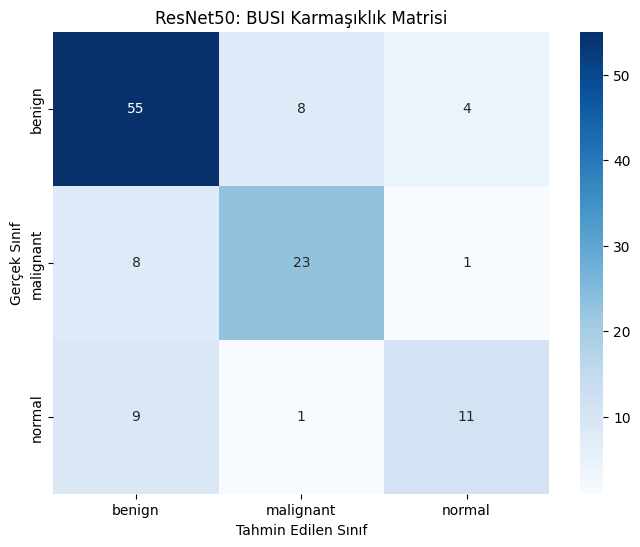

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. PARAMETRELER VE MODEL YÜKLEME
# Not: Eğer modelin ismi farklıysa burayı güncelle
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/Resnet_model_with_BUSI(4(2)).keras"
model = load_model(model_path)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_ROOT = "/content/datalar/" # Test verilerinin olduğu ana dizin

# 2. TEST VERİ YÜKLEYİCİ (ResNet Standartlarında)
# Önemli: Daha önceki eğitimde rescale=1./255 kullandıysan burada da onu kullanmalısın
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    DATA_ROOT + 'valid', # Veya 'test' klasörün varsa orası
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. TAHMİNLERİ AL
print("\n🔎 ResNet Test Tahminleri Yapılıyor...")
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
target_names = list(test_generator.class_indices.keys())

# 4. RAPORLAMA
print("\n" + "="*50)
print("📊 RESNET50 BUSI TEMEL EĞİTİM TEST RAPORU")
print("="*50)
print(classification_report(y_true, y_pred, target_names=target_names))

# 5. KARMAŞIKLIK MATRİSİ GÖRSELLEŞTİRME
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('ResNet50: BUSI Karmaşıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()